In [1]:
import pandas as pd
import numpy as np 
from scipy.spatial import distance
import string
import tqdm
import spacy
import matplotlib.pyplot as plt

--------

### Get the embeddings

In [2]:
nlp = spacy.load('fr_core_news_sm')

def lemmatisation(text):
    doc = nlp(str(text))
    lemma = ''
    for token in doc:
        lemma += token.lemma_ + ' '
    return lemma

res = []
with open('../data/gdn_common_sorted.txt') as file : 
    for j, line in enumerate(file): 
        if j > 0 : 
            res.append(line.split(' ')[:701])
res = np.asarray(res)
embedding = pd.DataFrame(res[:,1:], index=res[:,0])
embeded_words = {}

for word in embedding.index : 
    embeded_words[word.split('_')[0]] = word
    
data = pd.read_csv('../data/dataset_1.csv')

# Let's lemmatise the dataset : WARNING, it takes about 11 min !!, take a break and drink some coffee ;-)
new_data = pd.DataFrame(np.copy(data), columns=data.columns)
for i in tqdm.tqdm(range(len(data))):
    new_data['solution'][i] = lemmatisation(new_data['solution'][i])
    
data = new_data

100%|██████████| 15309/15309 [10:27<00:00, 24.39it/s]


--------

### Compute variance and distance for argumentation

In [3]:
def preprocess(sentence): 
    '''
    return the sentence passed in argmuents with no punctuation
    '''
    sentence = sentence.replace('\'',' ').lower()
    table = sentence.maketrans('', '', string.punctuation)
    sentence = [w.translate(table) for w in sentence]
    sentence = ''.join(sentence)

    return sentence

In [4]:
def embed_answer(sentence): 
    sentence_embedding = []
    sentence = preprocess(sentence)
    words = sentence.split(' ')
    words = list(set(words))
    for i, word in enumerate(words):
        try : 
            if embeded_words[word].endswith('_n'):
                sentence_embedding.append(embedding.loc[embeded_words[word]].tolist())
        except KeyError: 
            continue
    
    return(np.asarray(sentence_embedding, dtype=np.float64))
   
def compute_score(sentence_embedding, eval_type='var'):
    # Could be interesting to add a cosine evaluation !
    # Or count the clusters which are concerned by the sentence.
    # (after clustering of the embeddings -> use a grid_search or dendrograms.)
    result = 0
    n = len(sentence_embedding)
    if eval_type == 'var':
        for index in range(len(sentence_embedding[0])):
            result += np.var(sentence_embedding[:,index])
        result = result*n
            
    elif eval_type == 'dist':
        for word_1_idx in range(n-1):
            for word_2_idx in range(word_1_idx+1,n):
                result += np.linalg.norm(sentence_embedding[word_1_idx]-sentence_embedding[word_2_idx])
        
    elif eval_type == 'cos':
        for word_1_idx in range(n-1):
            for word_2_idx in range(word_1_idx+1,n):
                result += distance.cosine(sentence_embedding[word_1_idx],
                                          sentence_embedding[word_2_idx])
        
    elif eval_type == 'wrd_nb':
        result = n

    return result

In [5]:
data.head(5)

,Unnamed: 0,zip_code,problem,solution
0,1,57000,Les problèmes auxquels se trouve confronté l’e...,le problème auxquel se trouve confronter l’ en...
1,5,95330,La pollution de l'air,en matière de émission de c02 tout n' être pas...
2,6,84750,La biodiversité et la disparition de certaines...,"arrêter le pesticide , notamment le glyphosate..."
3,10,33820,La pollution de l'air,- réduire de manière drastique le déplacement ...
4,14,8500,Pollution air et mers,interdir très rapidement le emballage plastiqu...


###### Quick look at the sentences and some results

In [6]:
n_print = 15
for i in range(n_print): 
    sentence = data.iloc[i]['solution']
    print(preprocess(sentence))
    print('Variance = ',compute_score(embed_answer(sentence),eval_type='var'))
    print('Distance = ',compute_score(embed_answer(sentence),eval_type='dist'))
    print('Cosine = ',compute_score(embed_answer(sentence),eval_type='cos'))
    print('Nb_words<->Nb_subjects = ',compute_score(embed_answer(sentence),eval_type='wrd_nb'))
    
    words = sentence.split(' ')
    words = list(set(words))
    embedded_words = []
    for i, word in enumerate(words):
        try : 
            if word in embeded_words.keys() and embeded_words[word].endswith('_n'):
                #embedding.loc[embeded_words[word]].tolist()
                embedded_words.append(word)
        except KeyError: 
            continue
    print('Embedded words : ', embedded_words)
    print('-'*100)

le problème auxquel se trouve confronter l’ ensemble de le planète et que dénoncer  dans le plus parfait désordre  le gilet jaune de france ne être  il pas dus  avant tout  à le surpopulation mondial  ce population être passer d’15 milliard d’ habitant en 1900 à 7 milliard en 2020 et monter bientôt à 10 milliard vers 2040    avec le progrès de le communication dans ce village mondial  chaque individu  de fin fond de l’ asie au fin fond de l’ afrique  en passer par le « quartiers » et le « campagne » de notre pays  aspir à vivre – et on ne peu l’ en blâmer – comme le moins mal lotir de notre concitoyen  logement  nourriture  bien de consommation  déplacement  etc      voilà le mère de tout le problème  si tel être bien le cas  le solution à tout le problème  stabilisation de le croissance démographique  partage un richesse  partage un terre  partage de l’ eau  protection de le biodiversité  règlement un conflit  lutte contre le déforestation  lutte contre dérèglement climatique  règleme

Variance =  169.0242384762666
Distance =  411.9345751833918
Cosine =  63.79950819147174
Nb_words<->Nb_subjects =  13
Embedded words :  ['local', 'son', 'un', 'petit', 'surface', 'légume', 'commercialisation', 'production', 'transport', 'fruit', 'viande', 'profit', 'produit']
----------------------------------------------------------------------------------------------------
imposer à un constructeur automobile d’ accélérer le recherche  le développement et le déploiement de véhicule à hydrogène pour un mise en circulation le plus rapidement possible  en faire un ambition national pour que le france être le leader mondial dans ce domaine  
 dans le ville hors paris  rendre le transport en commun de proximité gratuit ou à tarif réduire  
Variance =  261.7458767506178
Distance =  991.8799225327978
Cosine =  155.66775533025668
Nb_words<->Nb_subjects =  20
Embedded words :  ['commun', 'développement', 'véhicule', 'domaine', 'recherche', 'constructeur', 'mise', 'leader', 'proximité', 'automo

--------

### Let's apply it to the whole dataset, we only focus on the solution proposed

In [7]:
eval_types = ['var','dist','cos','wrd_nb']
scores = []

for index in tqdm.tqdm(range(len(data))):
    answer = embed_answer(data.iloc[index]['solution'])
    if len(answer)>1:
        loc_score = [compute_score(answer, eval_type=eval_type) for eval_type in eval_types]
        n = loc_score[-1]
        new_loc_score = loc_score + [loc_score[0]/n,loc_score[1]*2/(n*(n-1)),loc_score[2]*2/(n*(n-1))]
        scores.append(new_loc_score)
    else:
        loc_score = [np.nan for eval_type in eval_types]
        new_loc_score = loc_score + [np.nan for eval_type in eval_types[:-1]]
        scores.append(new_loc_score)
        
        
# Total = 15309
scores_df = pd.DataFrame(data=np.array(scores),index=data.index, columns=['Variance', 'Distance', 
                                                                          'Cosine', 'Nouns_nb',
                                                                          'Variance_std', 'Distance_std', 
                                                                          'Cosine_std'])
argumentation_scores = pd.concat([data['zip_code'], scores_df], axis=1)
argumentation_scores.head(5)

100%|██████████| 15309/15309 [29:03<00:00,  8.78it/s] 


,zip_code,Variance,Distance,Cosine,Nouns_nb,Variance_std,Distance_std,Cosine_std
0,57000,809.534175,9205.700656,1525.837448,60.0,13.492236,5.200961,0.862055
1,95330,971.293685,14651.592748,2485.219451,77.0,12.614204,5.007380,0.849357
2,84750,332.953246,1662.744030,276.187905,26.0,12.805894,5.116135,0.849809
3,33820,335.188332,1578.285369,240.777449,25.0,13.407533,5.260951,0.802591
4,8500,206.174510,678.947936,110.072043,17.0,12.127912,4.992264,0.809353


new_scores = []
for index in range(len(scores)//2):
    new_scores.append(scores[2*index]+scores[2*index+1])
new_scores

scores_df = pd.DataFrame(data=np.array(new_scores),index=data.index, columns=['Variance', 'Distance', 
                                                                              'Cosine', 'Nouns_nb',
                                                                              'Variance_std', 'Distance_std', 
                                                                              'Cosine_std'])
argumentation_scores = pd.concat([data['zip_code'], scores_df], axis=1)
argumentation_scores.head(5)

--------

### Have a look at extreme values

In [8]:
values = argumentation_scores['Variance'].dropna().values
interesting_data = data.drop(argumentation_scores['Variance'].index[argumentation_scores['Variance'].apply(np.isnan)])
percentile = np.percentile(abs(values),99) # A tester avec 1 et < dans la ligne au dessous
interesting_values = values[abs(values)>percentile]
interesting_sentences = interesting_data[abs(values)<percentile]['solution']
for index in range(len(interesting_values)):
    sentence = preprocess(interesting_sentences.iloc[index])
    print(sentence)
    print('Variance = ', interesting_values[index])
    embedded_words = []
    for i, word in enumerate(sentence.split(' ')):
        try : 
            if word in embeded_words.keys() and embeded_words[word].endswith('_n'):
                #embedding.loc[embeded_words[word]].tolist()
                embedded_words.append(word)
        except KeyError: 
            continue
    print('Embedded words : ', embedded_words)
    print('-'*100)

le problème auxquel se trouve confronter l’ ensemble de le planète et que dénoncer  dans le plus parfait désordre  le gilet jaune de france ne être  il pas dus  avant tout  à le surpopulation mondial  ce population être passer d’15 milliard d’ habitant en 1900 à 7 milliard en 2020 et monter bientôt à 10 milliard vers 2040    avec le progrès de le communication dans ce village mondial  chaque individu  de fin fond de l’ asie au fin fond de l’ afrique  en passer par le « quartiers » et le « campagne » de notre pays  aspir à vivre – et on ne peu l’ en blâmer – comme le moins mal lotir de notre concitoyen  logement  nourriture  bien de consommation  déplacement  etc      voilà le mère de tout le problème  si tel être bien le cas  le solution à tout le problème  stabilisation de le croissance démographique  partage un richesse  partage un terre  partage de l’ eau  protection de le biodiversité  règlement un conflit  lutte contre le déforestation  lutte contre dérèglement climatique  règleme

interdire le usine à charbon dans tout le europe  faute de quoi un astreinte financier de pays concerné dans un banque de le transition écologique à créer  trouver un accord européen pour tout le compagnie aérien survoler le espace aérien européen pour taxer le kérosène  idem pour le fuel lourd un bateau cargo et bateal de croisière circuler dans notre espace maritime européen  le idée de taxer le poids lourd étranger circuler sur notre réseau routier devoir aboutir  pénaliser le entreprise ne faire pas le effort climatique  financer et accompagner davantage le recherche un bio carburant  le voiture à hydrogène  le bio diésel  le voiture à le eau  lutter contre le lobby avec plus de ténacité dans ce domaine  
Variance =  14.922347995159553
Embedded words :  ['usine', 'charbon', 'tout', 'faute', 'un', 'astreinte', 'financier', 'pays', 'un', 'banque', 'transition', 'un', 'accord', 'européen', 'tout', 'compagnie', 'espace', 'européen', 'kérosène', 'fuel', 'un', 'bateau', 'cargo', 'croisiè

--------

### Normalisation of the values

This method may not make much sense so we won't use it anymore...

In [98]:
with_counter = pd.concat([argumentation_scores, pd.DataFrame(np.array(word_counter))], axis=1)

# Then, let's compute the mean and variance values of the variances (resp. distance) 
# with respect to the number of words.
normalized_scores = pd.DataFrame(np.copy(argumentation_scores), columns=argumentation_scores.columns)

unique_word_nb = np.unique(word_counter, return_counts=True)
for word_nb, freq in tqdm.tqdm(zip(unique_word_nb[0],unique_word_nb[1])):
    for eval_type in ['Variance', 'Distance', 'Cosine']:
        if freq>1:
            corresponding_values=[]
            indexes=[]
            for idx in np.where(np.array(word_counter)==word_nb)[0]:
                if not np.isnan(argumentation_scores.iloc[idx][eval_type]): 
                    # If only one word or less is embedded, then the variance and distance value are nan
                    # and we mustn't consider them in the normalisation...
                    corresponding_values.append(argumentation_scores.iloc[idx][eval_type])
                    indexes.append(idx)

            mean_value = np.mean(corresponding_values)
            var_value = np.var(corresponding_values)

            for idx in indexes:
                normalized_scores.iloc[idx][eval_type] -= mean_value
                normalized_scores.iloc[idx][eval_type] /= var_value
                
normalized_scores.columns = ['zip_code','Variance_word_std','Distance_word_std', 
                             'Cosine_word_std','Nb_words','Freq']

normalized_scores = pd.concat([argumentation_scores['Variance'], 
                               argumentation_scores['Distance'],
                               argumentation_scores['Cosine'], normalized_scores], axis=1)

168it [00:46, 70.91it/s]/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
221it [00:46,  4.73it/s]


--------

### Add the department according to each zip_code

In [11]:
department = np.copy(argumentation_scores['zip_code'].values)
for dpt_idx in range(len(department)):
    if department[dpt_idx]>=1 and department[dpt_idx]<=95:
        continue
    elif department[dpt_idx]>=1000 and department[dpt_idx]<96000:
        department[dpt_idx] = int(department[dpt_idx]/1000)

department_df = pd.DataFrame(department, columns=['Department'])

final_data = pd.concat([department_df, argumentation_scores], axis=1)
final_data = final_data.dropna()
final_data['Nouns_nb'] = final_data['Nouns_nb'].astype(int)
final_data['zip_code'] = final_data['zip_code'].astype(int)
final_data['Department'] = final_data['Department'].astype(int)
final_data = final_data[final_data['Department']>=1]
final_data = final_data[final_data['Department']<=95]

print(final_data.shape)
final_data.head()

(15130, 9)


,Department,zip_code,Variance,Distance,Cosine,Nouns_nb,Variance_std,Distance_std,Cosine_std
0,57,57000,809.534175,9205.700656,1525.837448,60,13.492236,5.200961,0.862055
1,95,95330,971.293685,14651.592748,2485.219451,77,12.614204,5.007380,0.849357
2,84,84750,332.953246,1662.744030,276.187905,26,12.805894,5.116135,0.849809
3,33,33820,335.188332,1578.285369,240.777449,25,13.407533,5.260951,0.802591
4,8,8500,206.174510,678.947936,110.072043,17,12.127912,4.992264,0.809353


--------

### Let's plot the histograms Occ=f(Var) and Occ=f(Dist) for the most represented departments

75 295.94909966400473 35600.32307886071
69 319.84579185033954 40675.49056927809
31 290.4454909817893 31550.065055158084
13 302.79329444746287 37275.34955440139
92 300.77779973433326 39770.993038588145


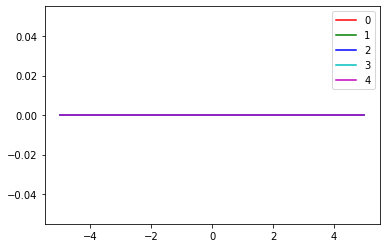

In [23]:
# Let's plot the hist for the most represented department
colors = ['r','g','b','c','m']
unique_dpt = np.unique(final_data['Department'], return_counts=True)
dpts = unique_dpt[0]
counts = unique_dpt[1]
for k in range(5):
    max_dpt_idx = np.argmax(counts)
    max_dpt = dpts[max_dpt_idx]

    values = final_data[final_data['Department']==max_dpt]['Variance'].dropna().values
    percentile = np.percentile(abs(values),95)
    valid_values = values[abs(values)<percentile]
    
    M = np.mean(valid_values)
    V = np.var(valid_values)
    print(max_dpt,M,V)
    gauss_pdf = lambda x,V,M: 1/np.sqrt(2*np.pi*V) * np.exp(-.5*(x-M)**2)
    X = np.linspace(-5,5,100)
    Y = []
    for elt in X:
        Y.append(gauss_pdf(elt,V,M))

    #final_data[final_data['Department']==max_dpt]['Variance'].hist(bins=2000, alpha=0.5)
    plt.plot(X,Y,color=colors[k%5],label=k)
    #plt.xlim(right=-5, left=5)
    #plt.ylim(bottom=0, top=2)
    counts = np.delete(counts,max_dpt_idx)
    dpts = np.delete(dpts,max_dpt_idx)
plt.legend()
plt.show()

--------

### Let's add the values to the dataframe

In [50]:
unique_dpt = np.unique(final_data['Department'], return_counts=True)[0]
mapping = {'Variance':{},'Distance':{},'Cosine':{},'Nouns_nb':{},
           'Variance_std':{}, 'Distance_std':{}, 'Cosine_std':{}}

for eval_type in mapping.keys():
    for dpt in unique_dpt:
        values = final_data[final_data['Department']==dpt][eval_type].dropna().values
        try:
            #percentile = np.percentile(abs(values),95)
            #valid_values = values[abs(values)<=percentile]
            #low_percentile = np.percentile(values,2.5)
            #high_percentile = np.percentile(values,97.5)
            #valid_values = values[values<=high_percentile]
            #valid_values = valid_values[valid_values>=low_percentile]
            valid_values = values

            M = np.median(valid_values) # makes more sense to consider the median value
            V = np.var(valid_values)
        except:
            M, V = np.nan, np.nan

        mapping[eval_type][dpt] = [M,V]
    
    
    # May need to add this to the dataframe... Then, uncomment the code below
    #try:
    #    final_data = final_data.drop(eval_type + '_mean_wrt_dpt', axis=1)
    #except:
    #    pass
    #means = []
    #for index in final_data.index:
    #    means.append(mapping[eval_type][final_data['Department'][index]][0])

    #means = pd.DataFrame(means, index=final_data.index, columns=[eval_type + '_mean_wrt_dpt'])
    #final_data = pd.concat([final_data, means], axis=1)

--------

### Plot the cartographie of the scores

In [51]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
pd.options.mode.chained_assignment = None  # default='warn'

def plot_cartography(Colors, eval_type, figsize=(10, 6)):
    # set the filepath and load in a shapefile
    fp = '../data/map_files.shp/departements-20180101.shp'
    map_df = gpd.read_file(fp)
    # check data type so we can see that this is not a normal dataframe, but a GEOdataframe
    merged = map_df.set_index('code_insee').join(Colors.set_index('code_insee'))
    merged['colors']['2A'] = merged['colors']['2B'] = Colors['colors'][20]
    merged['colors']['69D'] = merged['colors']['69M'] = Colors['colors'][69]
    for idx in merged.index:
        if idx not in Colors['code_insee'].values and idx!='2A' and idx!='2B' and idx!='69D' and idx!='69M':
            merged = merged.drop(index=idx)
    merged.head()

    # set a variable that will call whatever column we want to visualise on the map
    variable = 'colors'
    # set the range for the choropleth
    vmin, vmax = np.min(merged[variable].values)-1e-5, np.max(merged[variable].values)
    # create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=figsize)

    # create map
    merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

    ax.axis('off')

    ax.set_title("French Departments, colors correpond to the median of the argumentation scores : " + eval_type,
                 fontdict={'fontsize': '10', 'fontweight' : '3'})

    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # empty array for the data range
    sm._A = []
    # add the colorbar to the figure
    cbar = fig.colorbar(sm)

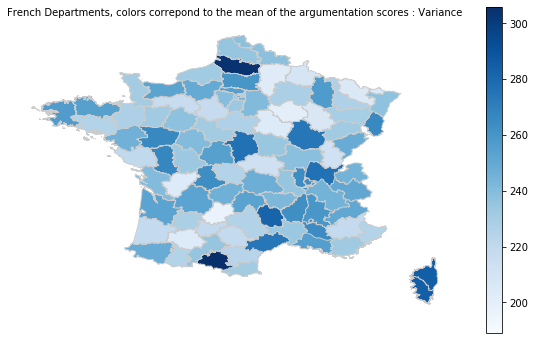

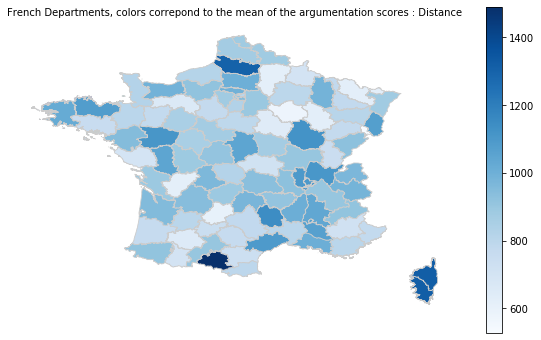

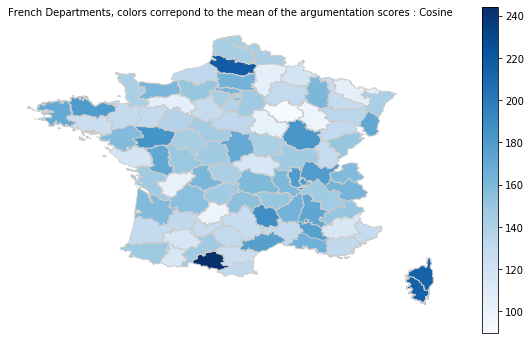

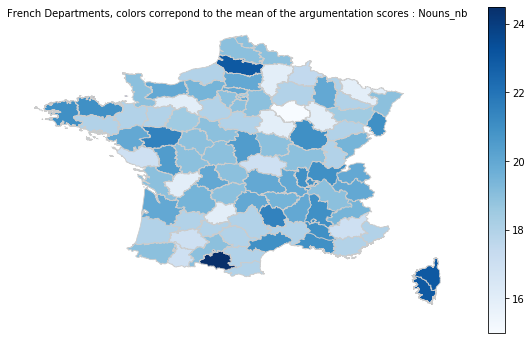

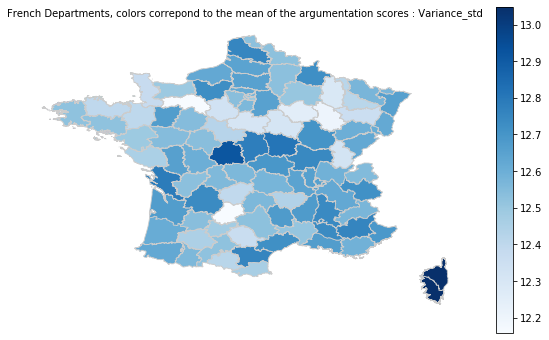

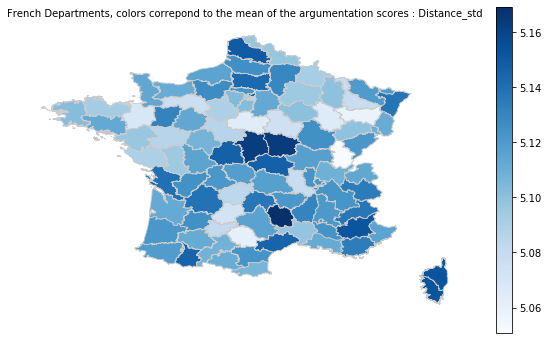

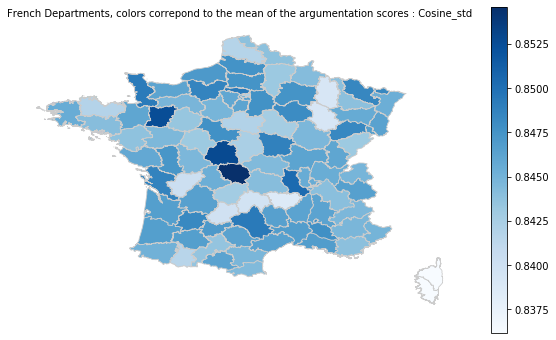

In [53]:
dpts = [k for k in range(1,96)]
for eval_type in ['Variance','Distance','Cosine','Nouns_nb',
                  'Variance_std', 'Distance_std', 'Cosine_std']:
    Colors = []
    for dpt in dpts:
        Colors.append(mapping[eval_type][dpt][0]) # Because in the geopandas the departments go from 0 to 94

    Colors = pd.DataFrame(Colors, index=dpts, columns=['colors'])
    Colors = pd.concat([Colors, pd.DataFrame(['0'+str(k) for k in range(1,10)] + [str(k) for k in range(10,96)],
                                             index=dpts, columns=['code_insee'])], axis=1)

    plot_cartography(Colors, eval_type, figsize=(10,6))
    plt.savefig('../../{}_median.png'.format(eval_type))

### Let's study the correlation with INSEE data

In [44]:
data_insee = pd.read_csv('../data/insee.csv',sep=';', skiprows=[0,1])
data_insee.index.name = 'zip_code'

agg_data = final_data.groupby(['zip_code']).mean()
indexes = []
for idx in agg_data.index:
    indexes.append(int(idx))
agg_data.index = indexes
agg_data.index.name = 'zip_code'

corr_data = data_insee.join(agg_data).dropna()

In [ ]:
titles = ['population density', 'wealth', 'education']
for index, insee in enumerate(["Densité de population (historique depuis 1876) 2016",
                               "Part des cadres et prof. intellectuelles sup. dans le nb d’emplois au LT 2016",
                               "Part des diplômés de l'enseignement sup. dans la pop. non scolarisée de 15 ans ou + 2016"]):
    fig, ax = plt.subplots(1, figsize=(8,8))
    for eval_type in ['Variance', 'Distance', 'Cosine', 'Nouns_nb', 
                      'Variance_std', 'Distance_std', 'Cosine_std']:
    
        test = corr_data.groupby([insee]).mean().dropna()
        
        #assert np.sort(test.index.values)==test.index.values # test if the indexes are sorted
        
        # Let's compute an average of the points to give it more sense statistically
        avg = {}
        for idx in range(len(test.index)):
            avg[idx] = [test.iloc[idx][eval_type]]
            i = 1
            while len(avg[idx])<5:
                try:
                    avg[idx].append(test.iloc[idx+i][eval_type])
                except:
                    pass
                try:
                    avg[idx].append(test.iloc[idx-i][eval_type])
                except:
                    pass
                i += 1
        # We don't want to propagate the mean, so we apply it afterwards
        for idx in range(len(test.index)):
            test.iloc[idx][eval_type] = np.mean(avg[idx])
        
        test[eval_type].plot(style='o')
        #plt.ylabel(eval_type)
        #ax.xlim(0,500)
        if index==0:
            ax.set_xlim([0, 500])
        ax.set_title('Our {0} score with respect to {1}'.format(eval_type,titles[index]))
        ax.legend()

--------

### ANOVA to assess the representativity of the results

In [39]:
import pandas as pd
from statsmodels.formula.api import ols

density_creteria = pd.read_csv('../data/grille_densite_2017.csv', sep=';')
density_creteria = density_creteria.set_index('s')
density_creteria.index.name = 'zip_code'

indexes = []
for idx in density_creteria.index:
    try:
        indexes.append(int(idx))
    except:
        if 'A' in idx:
            new_idx = idx.replace('A','0')
        if 'B' in idx:
            new_idx = idx.replace('B','0')
        indexes.append(int(new_idx))
density_creteria.index = indexes
new_cols = list(density_creteria.columns)
new_cols[1] = 'Typo'
density_creteria.columns = new_cols


anova_df = density_creteria.join(agg_data).dropna()
#import ipdb; ipdb.set_trace()

for eval_type in ['Variance', 'Distance', 'Cosine', 'Nouns_nb', 
                  'Variance_std', 'Distance_std', 'Cosine_std']:
    results = ols('{} ~ Typo'.format(eval_type), data=anova_df).fit()
    print(eval_type + ', p_value = {}'.format(results.pvalues['Typo']))

Variance, p_value = 0.46355305473802566
Distance, p_value = 0.9988952228378397
Cosine, p_value = 0.9990351398683224
Nouns_nb, p_value = 0.439167008584326
Variance_std, p_value = 0.42134900883784454
Distance_std, p_value = 0.8778652263301924
Cosine_std, p_value = 0.7640330186503284


In [41]:
from scipy import stats

for eval_type in ['Variance', 'Distance', 'Cosine', 'Nouns_nb', 
                  'Variance_std', 'Distance_std', 'Cosine_std']:

    x = anova_df[anova_df['Typo']==1][eval_type]
    y = anova_df[anova_df['Typo']==2][eval_type]
    z = anova_df[anova_df['Typo']==3][eval_type]
    t = anova_df[anova_df['Typo']==4][eval_type]

    print(eval_type + ', p_value = {}'.format(stats.kruskal(x,y,z,t)[1]))

Variance, p_value = 0.019768378145302086
Distance, p_value = 0.010074192555798544
Cosine, p_value = 0.010343136865251141
Nouns_nb, p_value = 0.017046832881985115
Variance_std, p_value = 0.6102551282045892
Distance_std, p_value = 0.4922115839194533
Cosine_std, p_value = 0.9917740095995814
